In [2]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION ---
sf.hbar = 1
np.random.seed(42)

# Parameters
eta, delta = 0.9, 0.01
num_steps = 100
learning_rate = 0.003  # Adjusted for epsilon optimization
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
mu = np.pi/4  # Fixed LO phase for this optimization

# --- Helper Functions ---
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

def epsilon_to_db(epsilon: float) -> float:
    """Convert epsilon to dB value"""
    t = np.tanh(epsilon)
    return -10.0 * np.log10(t)

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def compute_wigner_derivatives(epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Compute the derivatives of Wigner function with respect to eta and delta
    using central difference method
    """
    # Base Wigner function
    W_base = prepare_gkp_state(epsilon, eta, delta)
    
    # Compute dW/deta using central difference
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta/2, delta)
    W_eta_minus = prepare_gkp_state(epsilon, eta - d_eta/2, delta)
    dW_deta = (W_eta_plus - W_eta_minus) / d_eta
    
    # Compute dW/ddelta using central difference
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta/2)
    W_delta_minus = prepare_gkp_state(epsilon, eta, delta - d_delta/2)
    dW_ddelta = (W_delta_plus - W_delta_minus) / d_delta
    
    return W_base, dW_deta, dW_ddelta

def compute_qfi_bound(dW_deta, dW_ddelta):
    """
    Compute the QFI bound using Wigner function derivatives
    For multi-parameter case: F_total = F_eta_eta + F_delta_delta
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Compute F_eta_eta ≤ 4π∫(∂_η W)² dq dp
    F_eta_eta = 4 * np.pi * np.sum(dW_deta**2) * dq * dp
    
    # Compute F_delta_delta ≤ 4π∫(∂_δ W)² dq dp
    F_delta_delta = 4 * np.pi * np.sum(dW_ddelta**2) * dq * dp
    
    # Total QFI (trace of QFI matrix)
    F_total = F_eta_eta + F_delta_delta
    
    return F_total, F_eta_eta, F_delta_delta

def compute_qfi_gradient(epsilon, eta, delta, d_epsilon=1e-3):
    """
    Compute the gradient of the QFI bound with respect to epsilon
    using central difference method
    """
    # Compute QFI at epsilon + d_epsilon/2
    _, dW_deta_plus, dW_ddelta_plus = compute_wigner_derivatives(
        epsilon + d_epsilon/2, eta, delta)
    F_total_plus, _, _ = compute_qfi_bound(dW_deta_plus, dW_ddelta_plus)
    
    # Compute QFI at epsilon - d_epsilon/2
    _, dW_deta_minus, dW_ddelta_minus = compute_wigner_derivatives(
        epsilon - d_epsilon/2, eta, delta)
    F_total_minus, _, _ = compute_qfi_bound(dW_deta_minus, dW_ddelta_minus)
    
    # Compute gradient
    grad_epsilon = (F_total_plus - F_total_minus) / d_epsilon
    
    return grad_epsilon





c:\Users\tvle2\AppData\Local\anaconda3\envs\cv_Computing\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
# Main optimization loop
# Initialize with ~10 dB squeezing
epsilon = db_to_epsilon(10.0)
epsilon_min = db_to_epsilon(15.0)  # Maximum squeezing (~15 dB)
epsilon_max = db_to_epsilon(5.0)   # Minimum squeezing (~5 dB)

print(f"Initial epsilon: {epsilon:.4f} (equivalent to {epsilon_to_db(epsilon):.2f} dB)")

qfi_history, epsilon_history, gradient_history = [], [], []
velocity = 0
momentum = 0.9

for step in tqdm(range(num_steps)):
    # Compute Wigner derivatives
    W, dW_deta, dW_ddelta = compute_wigner_derivatives(epsilon, eta, delta)
    
    # Compute current QFI bound
    F_total, F_eta_eta, F_delta_delta = compute_qfi_bound(dW_deta, dW_ddelta)
    
    # Compute gradient of QFI with respect to epsilon
    grad_epsilon = compute_qfi_gradient(epsilon, eta, delta)
    
    # Clip gradient to prevent too large steps
    grad_epsilon = np.clip(grad_epsilon, -0.05, 0.05)
    
    # Momentum-based gradient ascent update
    velocity = momentum * velocity + learning_rate * grad_epsilon
    epsilon += velocity
    
    # Ensure epsilon stays within bounds
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)
    
    # Store history
    qfi_history.append(F_total)
    epsilon_history.append(epsilon)
    gradient_history.append(grad_epsilon)
    
    if step % 5 == 0:
        db_val = epsilon_to_db(epsilon)
        print(f"Step {step}: ε={epsilon:.4f} ({db_val:.2f} dB), " 
              f"QFI={F_total:.4e}, F_η={F_eta_eta:.4e}, F_δ={F_delta_delta:.4e}")


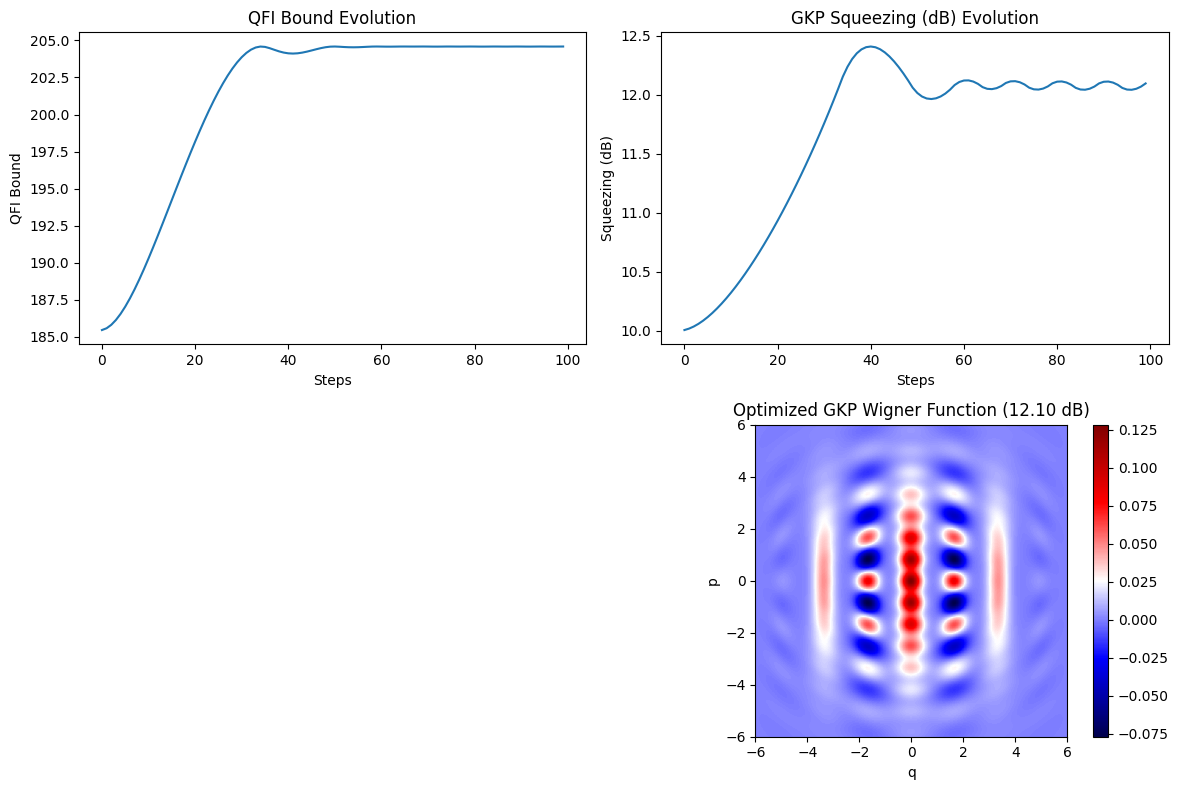

Optimization complete!
Final epsilon: 0.0618 (equivalent to 12.10 dB)
Final QFI bound: 2.045900e+02


In [9]:
# Plot results
plt.figure(figsize=(12, 8))

# Plot 1: QFI evolution
plt.subplot(2, 2, 1)
plt.plot(qfi_history)
plt.title('QFI Bound Evolution')
plt.xlabel('Steps')
plt.ylabel('QFI Bound')

# Plot 2: Epsilon evolution
plt.subplot(2, 2, 2)
plt.plot([epsilon_to_db(eps) for eps in epsilon_history])
plt.title('GKP Squeezing (dB) Evolution')
plt.xlabel('Steps')
plt.ylabel('Squeezing (dB)')


# Plot 4: Final Wigner function
plt.subplot(2, 2, 4)
plt.imshow(W, extent=[quad_axis[0], quad_axis[-1], quad_axis[0], quad_axis[-1]], 
           origin='lower', cmap='seismic')
plt.title(f'Optimized GKP Wigner Function ({epsilon_to_db(epsilon):.2f} dB)')
plt.xlabel('q')
plt.ylabel('p')
plt.colorbar()

plt.tight_layout()
plt.savefig('gkp_optimization_results.png')
plt.show()

print(f"Optimization complete!")
print(f"Final epsilon: {epsilon:.4f} (equivalent to {epsilon_to_db(epsilon):.2f} dB)")
print(f"Final QFI bound: {qfi_history[-1]:.6e}")

### Save the result

In [10]:
# Save the data to text files
# Basic version using NumPy's savetxt
np.savetxt(f'C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta{eta}_delta{delta}.txt', 
           np.column_stack((
               np.arange(len(qfi_history)),
               epsilon_history,
               [epsilon_to_db(eps) for eps in epsilon_history],
               qfi_history,
           )),
           delimiter='\t',
           header='Step\tEpsilon\tSqueezing(dB)\tQFI_Total',
           fmt=['%d', '%.6f', '%.4f', '%.6e'])

print(f"Optimization data saved to gkp_optimization_eta{eta}_delta{delta}.txt")

Optimization data saved to gkp_optimization_eta0.9_delta0.01.txt


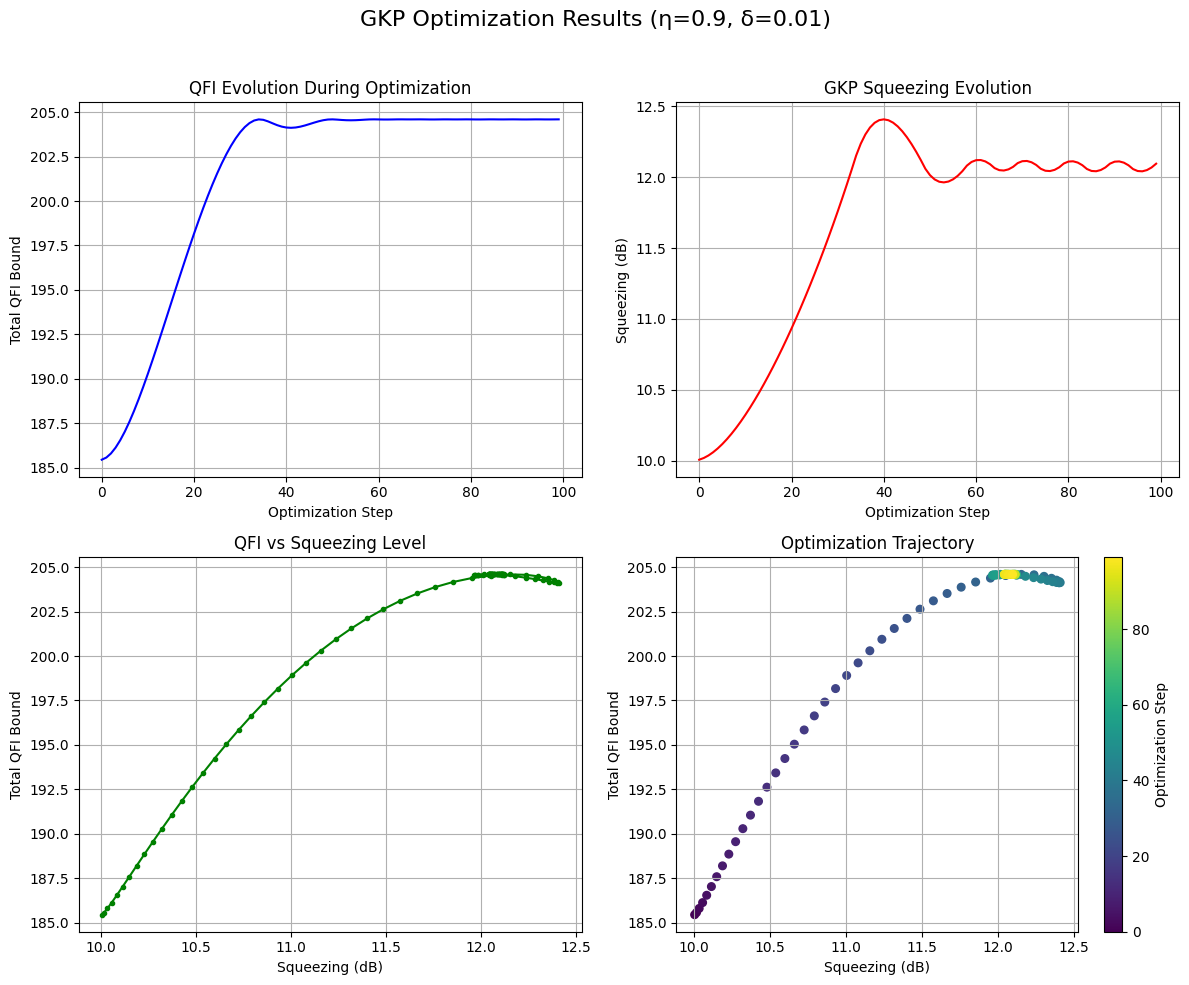

Optimization Summary for η=0.9, δ=0.01:
  Initial squeezing: 10.01 dB (ε=0.100185)
  Final squeezing: 12.10 dB (ε=0.061809)
  QFI improvement: 10.32%
  QFI range: [1.854594e+02, 2.045901e+02]


In [27]:
file_path = f'C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta{eta}_delta{delta}.txt'

# Load data from the text file
# skiprows=1 is needed to skip the header row
data = np.loadtxt(file_path, skiprows=1, delimiter='\t')

# Extract columns
steps = data[:, 0]
epsilon_values = data[:, 1]
squeezing_db = data[:, 2]
qfi_total = data[:, 3]

# Create a figure with multiple subplots
plt.figure(figsize=(12, 10))

# Plot 1: QFI evolution
plt.subplot(2, 2, 1)
plt.plot(steps, qfi_total, 'b-', markersize=3)
plt.title('QFI Evolution During Optimization')
plt.xlabel('Optimization Step')
plt.ylabel('Total QFI Bound')
plt.grid(True)

# Plot 2: Squeezing (dB) evolution
plt.subplot(2, 2, 2)
plt.plot(steps, squeezing_db, 'r-', markersize=3)
plt.title('GKP Squeezing Evolution')
plt.xlabel('Optimization Step')
plt.ylabel('Squeezing (dB)')
plt.grid(True)

# Plot 3: QFI vs Squeezing (dB)
plt.subplot(2, 2, 3)
plt.plot(squeezing_db, qfi_total, 'g-', marker='o', markersize=3)
plt.title('QFI vs Squeezing Level')
plt.xlabel('Squeezing (dB)')
plt.ylabel('Total QFI Bound')
plt.grid(True)

# Plot 4: Optimization trajectory in parameter space
plt.subplot(2, 2, 4)
plt.scatter(squeezing_db, qfi_total, c=steps, cmap='viridis', s=30)
plt.colorbar(label='Optimization Step')
plt.title('Optimization Trajectory')
plt.xlabel('Squeezing (dB)')
plt.ylabel('Total QFI Bound')
plt.grid(True)

# Add overall title with metadata
plt.suptitle(f'GKP Optimization Results (η={eta}, δ={delta})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle

# Save the figure
plt.savefig(f'gkp_optimization_analysis_eta{eta}_delta{delta}.png', dpi=300)
plt.show()

# Print optimization summary
print(f"Optimization Summary for η={eta}, δ={delta}:")
print(f"  Initial squeezing: {squeezing_db[0]:.2f} dB (ε={epsilon_values[0]:.6f})")
print(f"  Final squeezing: {squeezing_db[-1]:.2f} dB (ε={epsilon_values[-1]:.6f})")
print(f"  QFI improvement: {100*(qfi_total[-1]/qfi_total[0]-1):.2f}%")
print(f"  QFI range: [{np.min(qfi_total):.6e}, {np.max(qfi_total):.6e}]")

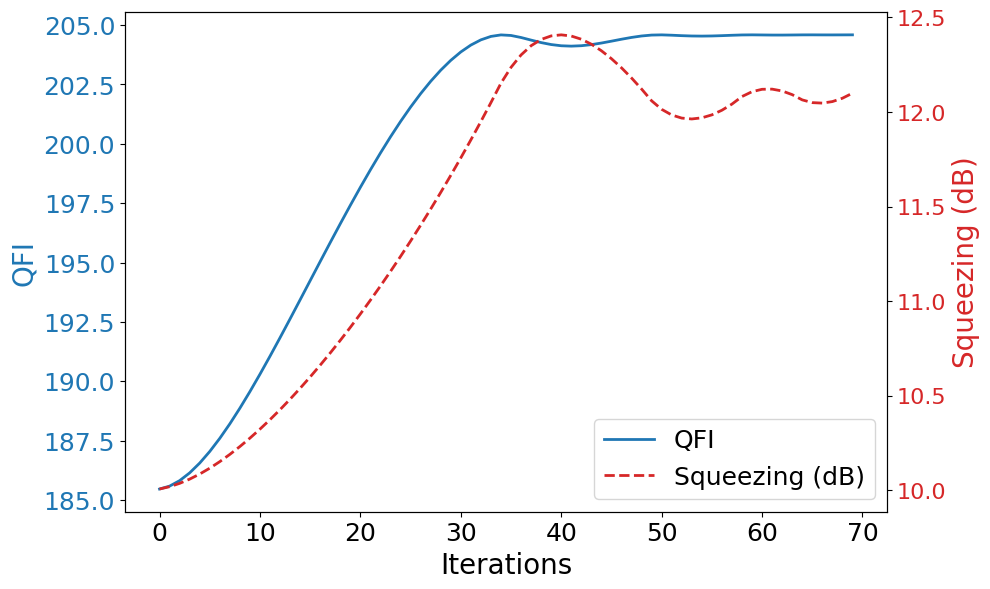

In [112]:
import matplotlib.pyplot as plt

steps_to_plot = 70  # Limit to the first 70 steps

fig, ax1 = plt.subplots(figsize=(10, 6))

color_qfi = 'tab:blue'
color_squeeze = 'tab:red'

# Slice data to the first 70 steps
qfi_to_plot = qfi_history[:steps_to_plot]
squeeze_to_plot = [epsilon_to_db(eps) for eps in epsilon_history[:steps_to_plot]]

# Plot QFI on primary y-axis
ax1.set_xlabel('Iterations', fontsize=20)
ax1.set_ylabel('QFI', fontsize=20, color=color_qfi)
ax1.plot(range(steps_to_plot), qfi_to_plot, color=color_qfi, linewidth=2, label='QFI')
ax1.tick_params(axis='y', labelcolor=color_qfi, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Create secondary y-axis for squeezing
ax2 = ax1.twinx()
ax2.set_ylabel('Squeezing (dB)', fontsize=20, color=color_squeeze)
ax2.plot(range(steps_to_plot), squeeze_to_plot, 
         color=color_squeeze, linewidth=2, linestyle='--', label='Squeezing (dB)')
ax2.tick_params(axis='y', labelcolor=color_squeeze, labelsize=18)

# ax1.grid(True)

# Legends (optional, recommended)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lines_qfi, labels_qfi = ax1.get_legend_handles_labels()
lines_squeeze, labels_squeeze = ax2.get_legend_handles_labels()
ax1.legend(lines_qfi + lines_squeeze, labels_qfi + labels_squeeze, fontsize=18, loc='best')

plt.tight_layout()
plt.savefig('combined_qfi_squeezing_evolution_70_steps.png', dpi=800)
plt.show()


Calculating channel propagation fidelity...


100%|██████████| 21/21 [06:06<00:00, 17.45s/it]


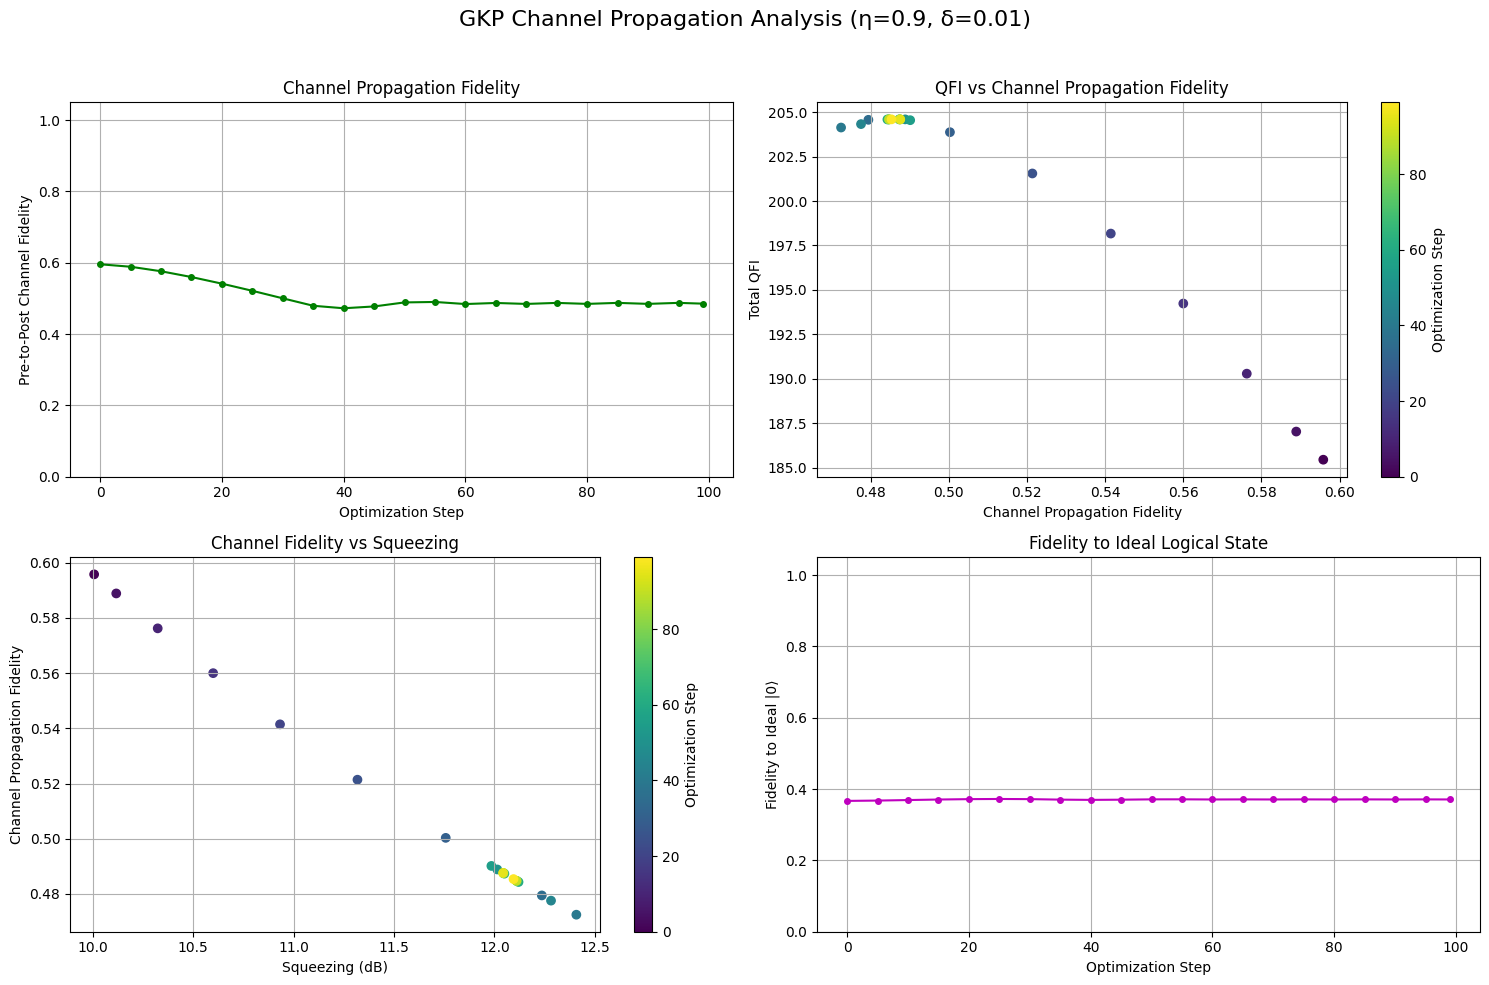

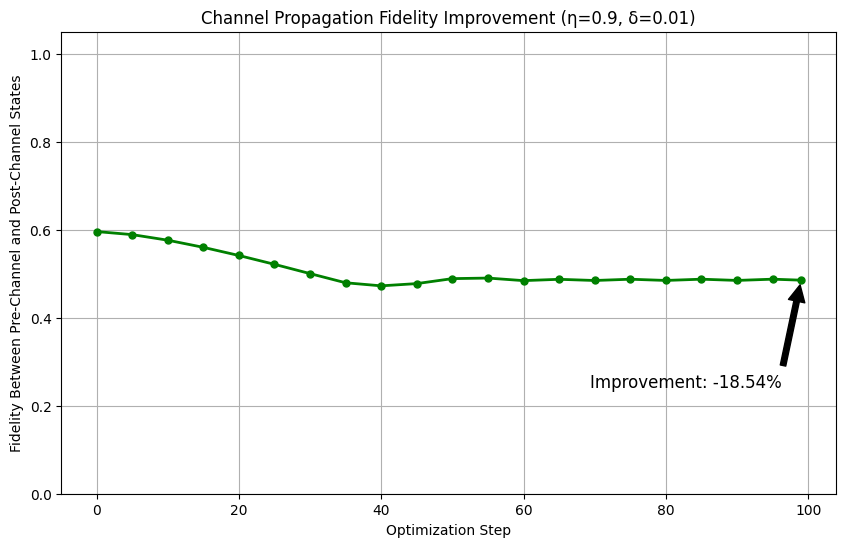


Channel Propagation Fidelity Analysis:
  Initial channel fidelity: 0.5958
  Final channel fidelity: 0.4854
  Improvement: -18.54%
  Correlation with QFI: -0.9793


In [5]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- Configuration ---
sf.hbar = 1
eta, delta = 0.9, 0.01  # Use your actual values
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)

def prepare_gkp_state(epsilon, eta, delta, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (delta)
    """
    # Your existing implementation
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(delta)
    if delta < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def calculate_fidelity(W1, W2):
    """
    Calculate fidelity between two quantum states represented by their Wigner functions.
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Normalize Wigner functions
    norm1 = np.sum(W1) * dq * dp
    norm2 = np.sum(W2) * dq * dp
    
    if np.abs(norm1) > 1e-10 and np.abs(norm2) > 1e-10:
        W1_norm = W1 / norm1
        W2_norm = W2 / norm2
    else:
        return 0.0
    
    # Calculate overlap integral
    overlap = np.sum(W1_norm * W2_norm) * dq * dp
    
    # Scale by 2π
    fidelity = 2 * np.pi * overlap
    
    # Ensure fidelity is between 0 and 1
    fidelity = np.clip(fidelity, 0, 1)
    
    return fidelity

# --- Load optimization data ---
file_path = f'C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta{eta}_delta{delta}.txt'
data = np.loadtxt(file_path, skiprows=1, delimiter='\t')

# Extract columns
steps = data[:, 0]
epsilon_values = data[:, 1]
squeezing_db = data[:, 2]
qfi_total = data[:, 3]

# --- Select sampling points ---
total_samples = min(20, len(epsilon_values))
sample_step = max(1, len(epsilon_values) // total_samples)

sample_indices = list(range(0, len(steps), sample_step))
if len(steps)-1 not in sample_indices:
    sample_indices.append(len(steps)-1)

sampled_steps = [int(steps[i]) for i in sample_indices]
sampled_epsilon = [epsilon_values[i] for i in sample_indices]
sampled_squeezing = [squeezing_db[i] for i in sample_indices]
sampled_qfi = [qfi_total[i] for i in sample_indices]

# --- Calculate channel propagation fidelity ---
print("Calculating channel propagation fidelity...")
channel_fidelity = []



for i, idx in enumerate(tqdm(sample_indices)):
    # Generate pre-channel state
    W_pre_channel = prepare_gkp_state(epsilon_values[idx], eta=1.0, delta=0.0)
    
    # Generate post-channel state
    W_post_channel = prepare_gkp_state(epsilon_values[idx], eta=eta, delta=delta)
    
    # Calculate channel fidelity (how well the state preserves after channel)
    channel_fid = calculate_fidelity(W_pre_channel, W_post_channel)
    channel_fidelity.append(channel_fid)
    
# --- Visualize the results ---
plt.figure(figsize=(15, 10))

# Plot 1: Channel Propagation Fidelity vs Optimization Step
plt.subplot(2, 2, 1)
plt.plot(sampled_steps, channel_fidelity, 'g-o', markersize=4)
plt.title('Channel Propagation Fidelity')
plt.xlabel('Optimization Step')
plt.ylabel('Pre-to-Post Channel Fidelity')
plt.ylim(0, 1.05)
plt.grid(True)

# Plot 2: QFI vs Channel Propagation Fidelity
plt.subplot(2, 2, 2)
plt.scatter(channel_fidelity, sampled_qfi, c=sampled_steps, cmap='viridis')
plt.colorbar(label='Optimization Step')
plt.title('QFI vs Channel Propagation Fidelity')
plt.xlabel('Channel Propagation Fidelity')
plt.ylabel('Total QFI')
plt.grid(True)

# Plot 3: Channel Fidelity vs Squeezing
plt.subplot(2, 2, 3)
plt.scatter(sampled_squeezing, channel_fidelity, c=sampled_steps, cmap='viridis')
plt.colorbar(label='Optimization Step')
plt.title('Channel Fidelity vs Squeezing')
plt.xlabel('Squeezing (dB)')
plt.ylabel('Channel Propagation Fidelity')
plt.grid(True)


# Add overall title
plt.suptitle(f'GKP Channel Propagation Analysis (η={eta}, δ={delta})', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'gkp_channel_propagation_analysis_eta{eta}_delta{delta}.png', dpi=300)
plt.show()

# --- Focused channel fidelity plot ---
plt.figure(figsize=(10, 6))
plt.plot(sampled_steps, channel_fidelity, 'g-o', markersize=5, linewidth=2)
plt.title(f'Channel Propagation Fidelity Improvement (η={eta}, δ={delta})')
plt.xlabel('Optimization Step')
plt.ylabel('Fidelity Between Pre-Channel and Post-Channel States')
plt.ylim(0, 1.05)
plt.grid(True)

# Add text annotation showing improvement
improvement = 100 * (channel_fidelity[-1] / channel_fidelity[0] - 1)
plt.annotate(f'Improvement: {improvement:.2f}%', 
             xy=(sampled_steps[-1], channel_fidelity[-1]),
             xytext=(0.7*sampled_steps[-1], 0.5*channel_fidelity[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12)

plt.savefig(f'gkp_channel_fidelity_improvement_eta{eta}_delta{delta}.png', dpi=300)
plt.show()

# Print summary statistics
print(f"\nChannel Propagation Fidelity Analysis:")
print(f"  Initial channel fidelity: {channel_fidelity[0]:.4f}")
print(f"  Final channel fidelity: {channel_fidelity[-1]:.4f}")
print(f"  Improvement: {improvement:.2f}%")
print(f"  Correlation with QFI: {np.corrcoef(channel_fidelity, sampled_qfi)[0,1]:.4f}")


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import strawberryfields as sf

# --- CONFIGURATION ---
sf.hbar = 1
eta, delta = 0.9, 0.01  # Loss and dephasing parameters
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)

# --- Helper Functions ---
def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """Prepare GKP state Wigner function under loss (eta) and dephasing (gamma)."""
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state_phi = eng.run(prog_phi).state
        wigner_avg += w * state_phi.wigner(0, quad_axis, quad_axis)
    return wigner_avg

# --- Helper Functions ---
def prepare_noisy_ideal_gkp_state(eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """Prepare GKP state Wigner function under loss (eta) and dephasing (gamma)."""
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0]) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog_phi = sf.Program(1)
        with prog_phi.context as q:
            sf.ops.GKP(state=[0,0]) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state_phi = eng.run(prog_phi).state
        wigner_avg += w * state_phi.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def generate_ideal_gkp_states(quad_axis):
    """
    Generate Wigner functions for ideal GKP |0> and |1> states.
    """
    # Create ideal GKP |0> state
    prog = sf.Program(1)
    with prog.context as q:
        sf.ops.GKP() | q
    eng = sf.Engine("bosonic")
    gkp_0 = eng.run(prog).state
    W_gkp_0 = gkp_0.wigner(0, quad_axis, quad_axis)

    # Create ideal GKP |1> state (displaced by sqrt(pi))
    prog = sf.Program(1)
    with prog.context as q:
        sf.ops.GKP() | q
        sf.ops.Xgate(np.sqrt(np.pi * sf.hbar)) | q
    eng = sf.Engine("bosonic")
    gkp_1 = eng.run(prog).state
    W_gkp_1 = gkp_1.wigner(0, quad_axis, quad_axis)

    return W_gkp_0, W_gkp_1


def calculate_fidelity(W1, W2):
    """Calculate fidelity between two quantum states using their Wigner functions."""
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Normalize Wigner functions
    norm1 = np.sum(W1) * dq * dp
    norm2 = np.sum(W2) * dq * dp
    W1_norm = W1 / norm1
    W2_norm = W2 / norm2
    
    # Calculate overlap integral
    overlap = np.sum(W1_norm * W2_norm) * dq * dp
    
    # Scale by 2π
    fidelity = 2 * np.pi * overlap
    
    # Ensure fidelity is between 0 and 1
    fidelity = np.clip(fidelity, 0, 1)
    
    return fidelity

def calculate_fnr_product(F_ideal, F_noise):
    """Calculate product-form FNR (improved metric)."""
    return F_ideal * (1 - F_noise)

def calculate_fnr_ratio(F_ideal, F_noise, eps=1e-6):
    """Calculate ratio-form FNR (improved metric)."""
    return F_ideal / (F_noise + eps)

# --- Load optimization data ---
file_path = f'C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta{eta}_delta{delta}.txt'
data = np.loadtxt(file_path, skiprows=1, delimiter='\t')

# Extract columns
steps = data[:, 0]
epsilon_values = data[:, 1]
squeezing_db = data[:, 2]
qfi_total = data[:, 3]

# --- Generate reference states ---

W_gkp_0, W_gkp_1 = generate_ideal_gkp_states(quad_axis)

# Fully decohered state

W_noise = prepare_noisy_ideal_gkp_state(eta=0.5, gamma=0.5)

# --- Sample subset of optimization steps for efficiency ---
total_samples = len(epsilon_values)
sample_step = max(1, len(epsilon_values) // total_samples)
sample_indices = list(range(0, len(steps), sample_step))
if len(steps)-1 not in sample_indices:
    sample_indices.append(len(steps)-1)

sampled_steps = [int(steps[i]) for i in sample_indices]
sampled_epsilon = [epsilon_values[i] for i in sample_indices]
sampled_qfi = [qfi_total[i] for i in sample_indices]

# --- Calculate fidelities and FNR metrics ---
fidelity_ideal = []
fidelity_noise = []
fnr_ratio = []

print("Calculating FNR metrics...")
for idx in tqdm(sample_indices):
    # Generate current state
    W_current = prepare_gkp_state(epsilon=epsilon_values[idx], eta=eta, gamma=delta)
    
    # Calculate fidelities
    f_ideal = calculate_fidelity(W_current, W_gkp_0)
    f_noise = calculate_fidelity(W_current, W_noise)

    # Store values
    fidelity_ideal.append(f_ideal)
    fidelity_noise.append(f_noise)
    
    fnr_ratio.append(calculate_fnr_ratio(f_ideal, f_noise))




Calculating FNR metrics...


100%|██████████| 100/100 [29:19<00:00, 17.59s/it]


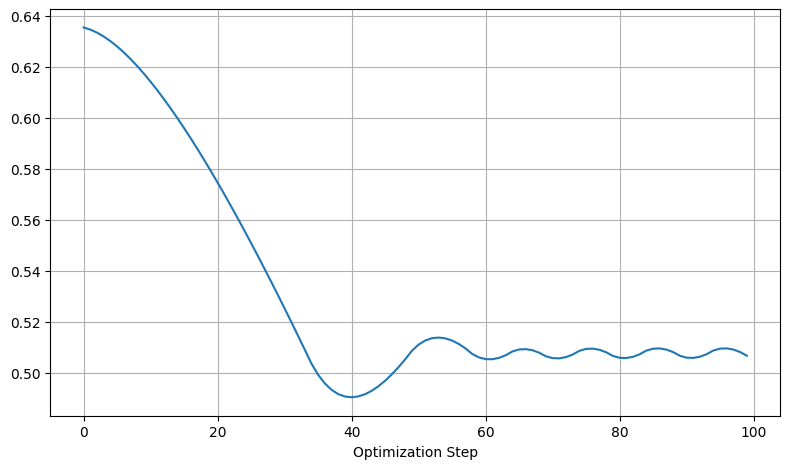

In [7]:
# --- Create visualization ---
plt.figure(figsize=(8, 5))

plt.plot(sampled_steps, fidelity_ideal)
# plt.title('Ratio-Form FNR (F_ideal / (F_noise + ε))')
plt.xlabel('Optimization Step')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig(f'gkp_revised_fnr_analysis_eta{eta}_delta{delta}.png', dpi=300)
plt.show()



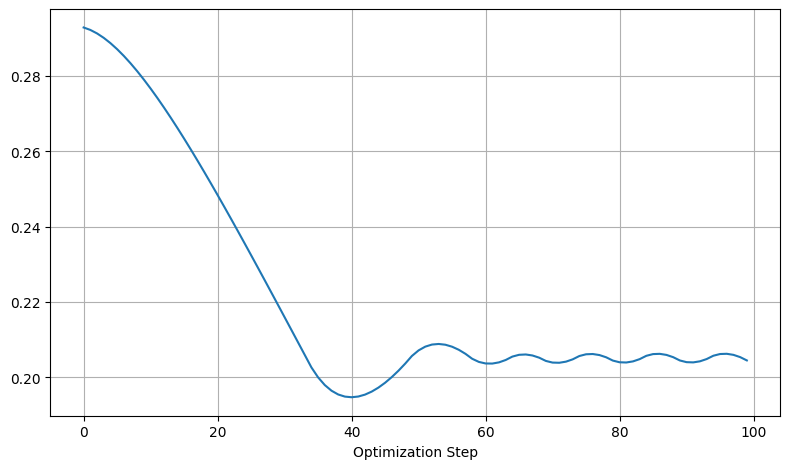

In [ ]:
# --- Create visualization ---
plt.figure(figsize=(8, 5))

plt.plot(sampled_steps, fidelity_noise)
plt.xlabel('Optimization Step')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



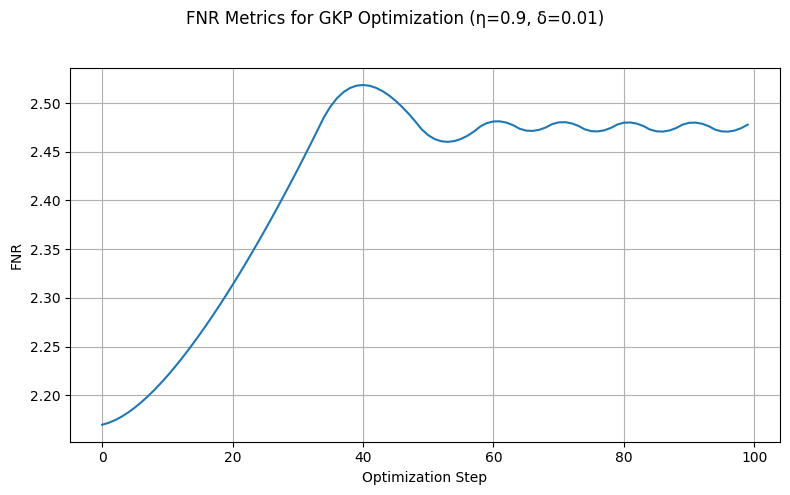

In [9]:
# --- Create visualization ---
plt.figure(figsize=(8, 5))

plt.plot(sampled_steps, fnr_ratio)
# plt.title('Ratio-Form FNR (F_ideal / (F_noise + ε))')
plt.xlabel('Optimization Step')
plt.ylabel('FNR')
plt.grid(True)


plt.suptitle(f'FNR Metrics for GKP Optimization (η={eta}, δ={delta})', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig(f'gkp_revised_fnr_analysis_eta{eta}_delta{delta}.png', dpi=300)
plt.show()



In [48]:
print(len(fnr_ratio))

100


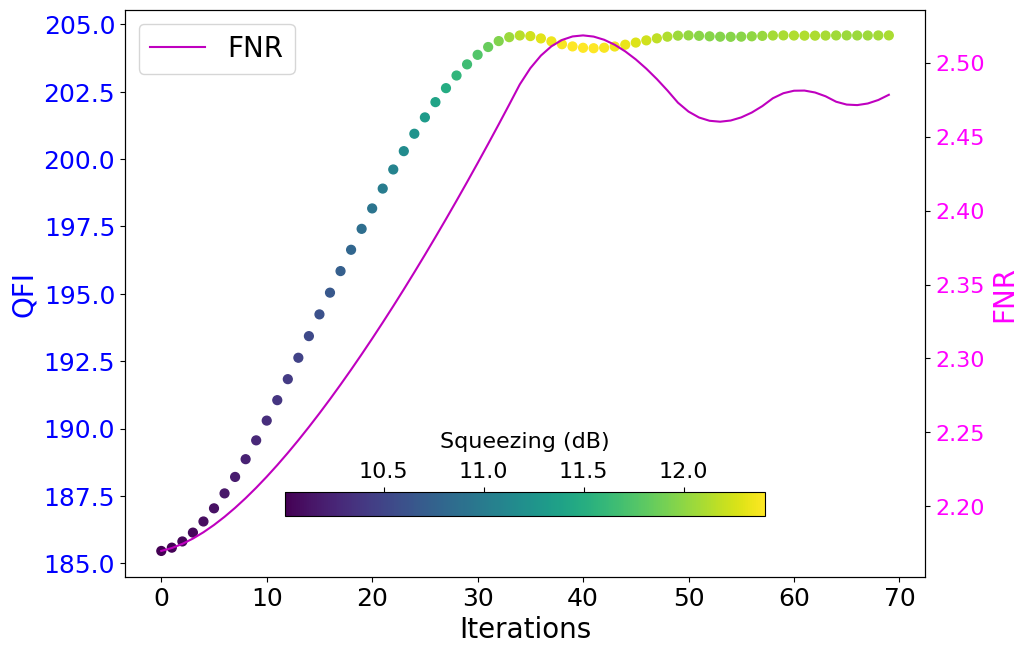

In [125]:
# Limit optimization steps to 70
steps_limited = steps[:70]
qfi_total_limited = qfi_total[:70]
fnr_ratio_limited = fnr_ratio[:70]
squeezing_db_limited = squeezing_db[:70]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Optimization Trajectory (QFI vs Steps) on primary y-axis
scatter = ax1.scatter(steps_limited, qfi_total_limited, c=squeezing_db_limited, cmap='viridis', s=40)
ax1.set_xlabel('Iterations',  fontsize=20)
ax1.set_ylabel('QFI', color='blue',  fontsize=20)
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=18)
# ax1.set_title('Optimization Trajectory and FNR')

# Plot FNR on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(steps_limited, fnr_ratio_limited, 'm', label='FNR')
ax2.set_ylabel('FNR', color='magenta',  fontsize=20)
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=18)


# Add horizontal colorbar for squeezing levels
cbar = fig.colorbar(scatter, ax=ax1, orientation="horizontal", shrink=0.6, pad=0.3)  # Horizontal orientation
cbar.ax.xaxis.set_label_position('top')  # Move label to the top
cbar.ax.xaxis.set_ticks_position('top')  # Move ticks to the top as well
cbar.set_label('Squeezing (dB)', fontsize = 16, labelpad=10)
cbar.ax.tick_params(labelsize=16)

# Add grid and legend
# ax1.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax2.legend(loc='upper left',  fontsize=20)

# Save the figure
plt.tight_layout()
plt.savefig(f'gkp_optimization_trajectory_fnr_eta{eta}_delta{delta}_limited_horizontal_cbar.png', dpi=800)
plt.show()


# MSE

In [1]:
filename_cfi = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/CFI/fisher_history_10.txt"
filename_mu = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/CFI/mu_10.txt"
filename_qfi = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta0.9_delta0.01.txt"


# Load mu values
mu_data = np.loadtxt(filename_mu)
mu_history = mu_data[:, 1]

# Load epsilon values from QFI file
qfi_data = np.loadtxt(filename_qfi, delimiter='\t', skiprows=1)
epsilon_history = qfi_data[:, 1]

# True parameters
eta_true, delta_true = 0.9, 0.01

# --- Helper Functions (reuse from previous snippet) ---

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")
    phi_std = np.sqrt(gamma)

    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]
    dp = dq
    X = Q * np.cos(phi) + P * np.sin(phi)

    P_x = np.zeros_like(xvec, dtype=float)
    for i in range(len(xvec)):
        for j in range(len(xvec)):
            idx = int(np.floor((X[i, j] - xvec[0]) / dq))
            if 0 <= idx < len(xvec):
                P_x[idx] += W[i, j] * dq * dp
    P_x /= np.trapz(P_x, xvec)
    return P_x

def estimate_parameters(P_measurement, mu, epsilon, eta_vals, delta_vals):
    best_eta, best_delta = eta_vals[0], delta_vals[0]
    min_dist = np.inf
    for eta_trial in eta_vals:
        for delta_trial in delta_vals:
            try:
                W_trial = prepare_gkp_state(epsilon, eta_trial, delta_trial)
                P_trial = marginal_from_wigner(W_trial, quad_axis, mu) + 1e-12
                # Use L2 distance for numerical stability
                dist = np.sum((P_measurement - P_trial)**2)
                if dist < min_dist:
                    min_dist = dist
                    best_eta, best_delta = eta_trial, delta_trial
            except:
                continue
    return best_eta, best_delta

def compute_mse(mu, epsilon, eta_true, delta_true, num_trials=3, noise_level=1e-3):
    eta_estimates, delta_estimates = [], []
    eta_grid = np.linspace(eta_true - 0.02, eta_true + 0.02, 5)
    delta_grid = np.linspace(delta_true - 0.002, delta_true + 0.002, 5)
    W_true = prepare_gkp_state(epsilon, eta_true, delta_true)
    P_true = marginal_from_wigner(W_true, quad_axis, mu) + 1e-12

    for _ in range(num_trials):
        P_noisy = P_true + noise_level * np.random.randn(len(P_true))
        P_noisy = np.clip(P_noisy, 0, None)
        P_noisy /= np.trapz(P_noisy, quad_axis)
        eta_hat, delta_hat = estimate_parameters(P_noisy, mu, epsilon, eta_grid, delta_grid)
        eta_estimates.append(eta_hat)
        delta_estimates.append(delta_hat)

    mse_eta = np.mean((np.array(eta_estimates) - eta_true)**2)
    mse_delta = np.mean((np.array(delta_estimates) - delta_true)**2)
    return mse_eta, mse_delta

# --- Compute MSE for each optimization step ---

mse_eta_mu, mse_delta_mu = [], []
mse_eta_eps, mse_delta_eps = [], []

print("Calculating MSE for mu optimization...")
for mu in tqdm(mu_history[:10]):
    mse_eta, mse_delta = compute_mse(mu, db_to_epsilon(10), eta_true, delta_true)
    mse_eta_mu.append(mse_eta)
    mse_delta_mu.append(mse_delta)

print("Calculating MSE for epsilon optimization...")
for epsilon in tqdm(epsilon_history[:5]):
    mse_eta, mse_delta = compute_mse(np.pi/4, epsilon, eta_true, delta_true)
    mse_eta_eps.append(mse_eta)
    mse_delta_eps.append(mse_delta)


Calculating MSE for mu optimization...


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:

# --- Plotting Results ---

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# MSE for mu optimization (CFI)
axs[0].plot(mse_eta_mu, label='MSE η (Loss)')
axs[0].plot(mse_delta_mu, label='MSE δ (Dephasing)')
axs[0].set_yscale('log')
axs[0].set_title('MSE vs Steps (μ optimization - CFI)')
axs[0].set_xlabel('Optimization Step')
axs[0].set_ylabel('MSE')
axs[0].legend()
axs[0].grid(True)

# MSE for epsilon optimization (QFI)
axs[1].plot(mse_eta_eps, label='MSE η (Loss)')
axs[1].plot(mse_delta_eps, label='MSE δ (Dephasing)')
axs[1].set_yscale('log')
axs[1].set_title('MSE vs Steps (ε optimization - QFI)')
axs[1].set_xlabel('Optimization Step')
axs[1].set_ylabel('MSE')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()